In [465]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pandas as pd

In [466]:
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128, shuffle=True)

test_dataset = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [467]:
class DNN(nn.Module):
    def __init__(self,input_size, output_size, hidden_layers  = [], drop_p = 0.3):
        super(DNN, self).__init__()
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hl = len(hidden_layers)
        if self.hl!=0:
            self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
            self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
            self.output = nn.Linear(hidden_layers[-1], output_size)
        else:
            self.hidden_layers = nn.ModuleList([nn.Linear(input_size, output_size)])
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            #x = nn.BatchNorm1d(x.shape[1]).to(device)(x)
            #x = self.dropout(x)
        if self.hl!=0:
            x = self.output(x)
        
        return x
    
class CNN_unit(nn.Module):
    def __init__(self, in_channel ,out_channel, kernel_size,padding=0):
        super(CNN_unit, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.cnn2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.bn = nn.BatchNorm2d(out_channel)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        self.p = nn.Dropout(p = 0.25)
        
    def forward(self, x):
        x = self.cnn1(x)
        #x = self.p(x)
        x = self.bn(x)
        x = torch.relu(x)
        
        x = self.maxpool(x)
        
        x = self.cnn2(x)
        x = self.bn(x)
        x = F.relu(x)
        return x


class mnist_model(nn.Module):
    def __init__(self):
        super(mnist_model, self).__init__()
        self.cnn1 = CNN_unit(1, 8, 5)
        self.cnn2 = CNN_unit(8, 8, 8)
        self.linear_m = DNN(8*4*4,20,[64,128,256])
        self.linear_s = DNN(8*4*4,20,[64,128,256])
        
        self.linear1 = DNN(20,1*28*28,[64,128,256])
        self.cnn4 = CNN_unit(6,5,4)
        self.cnn5 = CNN_unit(5,5,4,4)
        #self.cnn5 = CNN_unit(4,1,5,6)
        self.cnn6 = CNN_unit(5,2,3,4)
        self.cnn7 = CNN_unit(2,1,3,3)
        self.cnn8 = CNN_unit(1,1,3,2)
        
    def encode(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = x.view(-1,8*4*4)
        m = self.linear_m(x)
        s = self.linear_s(x)
        return m,s
    
    def decode(self, z):
        z = self.linear1(z)
        
        #z = z.view(-1,6,8,8)
        
        #z = self.cnn4(z)

        #z = self.cnn5(z)
        #z = self.cnn6(z)
       
        #z = self.cnn7(z)
        #z = self.cnn8(z)
        #print(z.shape)
        return z
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        m,s = self.encode(x)
        z = self.reparameterize(m,s)
        #print(z.shape)
        z = self.decode(z)
        z = torch.sigmoid(z)
        #print(z.shape)
        return z,m,s
    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1,784), x.view(-1,784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [468]:
model = mnist_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience = 3, verbose = True)

def train(epoch):
    log_interval = 10
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
        scheduler.step(loss.item())

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
epochs = 10
for epoch in range(1,10 + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.170471
Train Epoch: 1 [1280/60000 (2%)]	Loss: 416.950165
Train Epoch: 1 [2560/60000 (4%)]	Loss: 233.247681
Train Epoch: 1 [3840/60000 (6%)]	Loss: 220.577667
Train Epoch: 1 [5120/60000 (9%)]	Loss: 205.862915
Train Epoch: 1 [6400/60000 (11%)]	Loss: 204.152451
Train Epoch: 1 [7680/60000 (13%)]	Loss: 203.167603
Train Epoch: 1 [8960/60000 (15%)]	Loss: 213.250473
Train Epoch: 1 [10240/60000 (17%)]	Loss: 202.738495
Train Epoch: 1 [11520/60000 (19%)]	Loss: 203.782928
Train Epoch: 1 [12800/60000 (21%)]	Loss: 201.197891
Train Epoch: 1 [14080/60000 (23%)]	Loss: 196.221436
Train Epoch: 1 [15360/60000 (26%)]	Loss: 200.127411
Train Epoch: 1 [16640/60000 (28%)]	Loss: 199.406525
Train Epoch: 1 [17920/60000 (30%)]	Loss: 198.954742
Train Epoch: 1 [19200/60000 (32%)]	Loss: 198.751755
Train Epoch: 1 [20480/60000 (34%)]	Loss: 199.285217
Train Epoch: 1 [21760/60000 (36%)]	Loss: 191.489258
Train Epoch: 1 [23040/60000 (38%)]	Loss: 191.493271
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [20480/60000 (34%)]	Loss: 144.165009
Train Epoch: 4 [21760/60000 (36%)]	Loss: 141.639175
Train Epoch: 4 [23040/60000 (38%)]	Loss: 140.235245
Train Epoch: 4 [24320/60000 (41%)]	Loss: 138.671616
Train Epoch: 4 [25600/60000 (43%)]	Loss: 139.183701
Train Epoch: 4 [26880/60000 (45%)]	Loss: 139.832565
Train Epoch: 4 [28160/60000 (47%)]	Loss: 144.419159
Train Epoch: 4 [29440/60000 (49%)]	Loss: 142.511688
Train Epoch: 4 [30720/60000 (51%)]	Loss: 134.676880
Train Epoch: 4 [32000/60000 (53%)]	Loss: 138.669937
Train Epoch: 4 [33280/60000 (55%)]	Loss: 142.660324
Train Epoch: 4 [34560/60000 (58%)]	Loss: 148.393570
Train Epoch: 4 [35840/60000 (60%)]	Loss: 137.926727
Train Epoch: 4 [37120/60000 (62%)]	Loss: 141.384140
Train Epoch: 4 [38400/60000 (64%)]	Loss: 131.590073
Train Epoch: 4 [39680/60000 (66%)]	Loss: 139.083389
Train Epoch: 4 [40960/60000 (68%)]	Loss: 144.563217
Train Epoch: 4 [42240/60000 (70%)]	Loss: 137.035095
Train Epoch: 4 [43520/60000 (72%)]	Loss: 153.374878
Train Epoch:

Train Epoch: 7 [40960/60000 (68%)]	Loss: 143.417923
Train Epoch: 7 [42240/60000 (70%)]	Loss: 130.163849
Train Epoch: 7 [43520/60000 (72%)]	Loss: 134.358856
Train Epoch: 7 [44800/60000 (75%)]	Loss: 136.364349
Train Epoch: 7 [46080/60000 (77%)]	Loss: 131.198120
Train Epoch: 7 [47360/60000 (79%)]	Loss: 128.469101
Train Epoch: 7 [48640/60000 (81%)]	Loss: 136.417328
Train Epoch: 7 [49920/60000 (83%)]	Loss: 134.837433
Train Epoch: 7 [51200/60000 (85%)]	Loss: 131.979309
Train Epoch: 7 [52480/60000 (87%)]	Loss: 129.314468
Train Epoch: 7 [53760/60000 (90%)]	Loss: 138.366898
Train Epoch: 7 [55040/60000 (92%)]	Loss: 128.685913
Train Epoch: 7 [56320/60000 (94%)]	Loss: 134.843369
Train Epoch: 7 [57600/60000 (96%)]	Loss: 130.324081
Train Epoch: 7 [58880/60000 (98%)]	Loss: 135.069733
====> Epoch: 7 Average loss: 134.3257
Train Epoch: 8 [0/60000 (0%)]	Loss: 136.583130
Train Epoch: 8 [1280/60000 (2%)]	Loss: 134.621338
Train Epoch: 8 [2560/60000 (4%)]	Loss: 133.266937
Train Epoch: 8 [3840/60000 (6%)]	Lo

====> Epoch: 10 Average loss: 130.6767


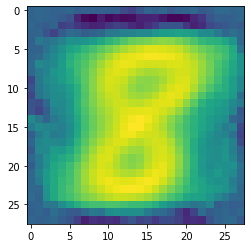

In [469]:
im_data = np.random.normal(0,1,20)
T = torch.tensor(im_data).float()
image = model.decode(T).detach().numpy()
plt.imshow(image.reshape((28,28)))

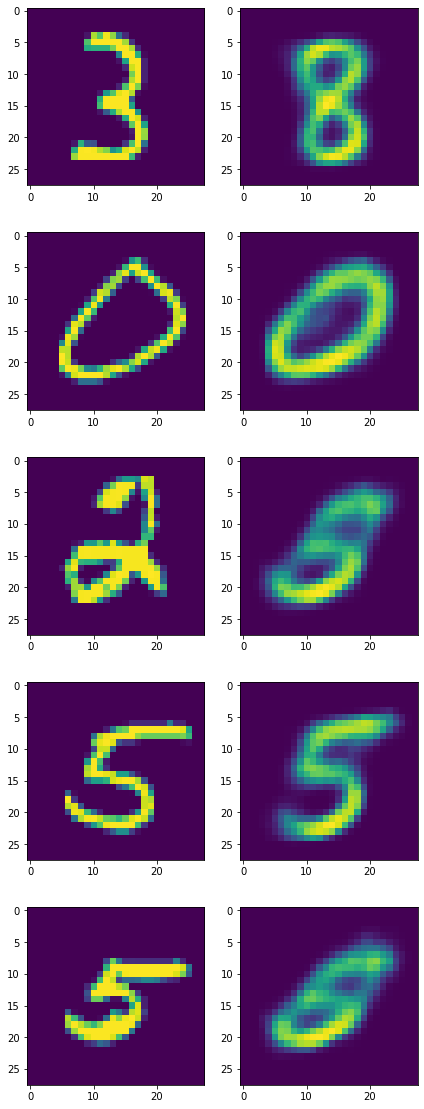

In [499]:
fig, axes = plt.subplots(5,2,figsize = (7,20))


indices = np.random.randint(0,len(train_dataset),(5))

for i,idx in enumerate(indices):
    input_ = train_dataset[idx][0]
    axes[i][0].imshow(input_.detach().numpy().reshape((28,28)))

    image = model(input_.view(-1,1,28,28))[0]
    axes[i][1].imshow(image.detach().numpy().reshape((28,28)))